In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2
import os
import zipfile

import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

import matplotlib.gridspec as gridspec

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')


In [2]:
data = np.load('C:\Personal\AI\Computer_Vision\images.npy', allow_pickle = True)

In [3]:
data.shape

(409, 2)

[[[  4   0   1]
  [  0   3   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   2]
  [  5   1   2]]

 [[  0   2   1]
  [ 69  81  71]
  [ 72  79  71]
  ...
  [111 121 122]
  [113 122 121]
  [  0   0   0]]

 [[  0   0   0]
  [ 71  83  71]
  [ 70  81  67]
  ...
  [113 123 125]
  [114 122 124]
  [  0   0   0]]

 ...

 [[  0   3   0]
  [ 68  76  65]
  [ 67  78  62]
  ...
  [145 155 120]
  [133 143 106]
  [  0   1   3]]

 [[  1   1   0]
  [ 69  72  61]
  [ 67  73  59]
  ...
  [148 155 121]
  [137 145 104]
  [  0   1   3]]

 [[  1   1   3]
  [  1   1   1]
  [  0   0   2]
  ...
  [  0   0   0]
  [  0   0   2]
  [  0   0   0]]]


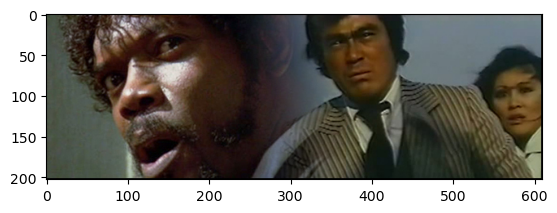

In [4]:
print(data[70][0])
plt.imshow(data[70][0])

In [5]:
data[70][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.05901639344262295, 'y': 0.04433497536945813},
   {'x': 0.460655737704918, 'y': 0.9753694581280788}],
  'imageWidth': 610,
  'imageHeight': 203},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5131147540983606, 'y': 0.04926108374384237},
   {'x': 0.760655737704918, 'y': 0.5812807881773399}],
  'imageWidth': 610,
  'imageHeight': 203},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.8967213114754098, 'y': 0.2315270935960591},
   {'x': 1, 'y': 0.6600985221674877}],
  'imageWidth': 610,
  'imageHeight': 203}]

In [6]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [7]:
print('TensorFlow Version: ', tf.__version__)
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

TensorFlow Version:  2.14.0


In [8]:
print('Shape of X_train: ', X_train.shape)
print('Shape of mask array: ', masks.shape)

Shape of X_train:  (409, 224, 224, 3)
Shape of mask array:  (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

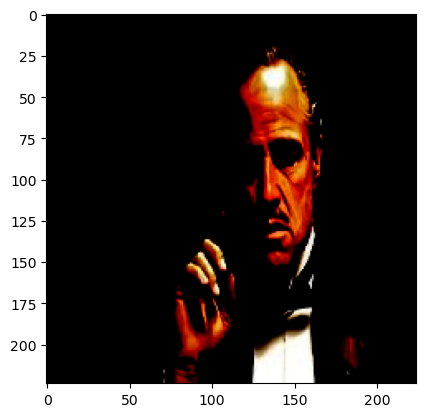

In [9]:
n = 10
print(X_train[n])
plt.imshow(X_train[n])

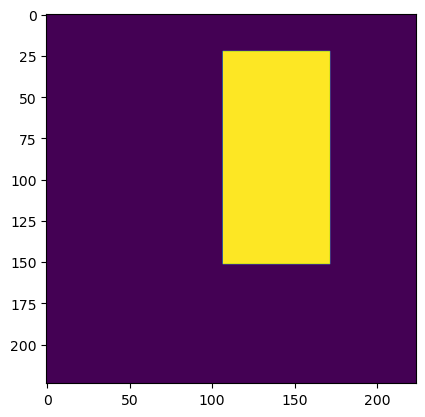

In [10]:
plt.imshow(masks[n])

In [11]:
def create_model(trainable = True):
    IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    model = MobileNet(input_shape = IMG_SHAPE, alpha = 1.0, include_top = False, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer('conv_pw_1_relu').output
    block1 = model.get_layer('conv_pw_3_relu').output
    block2 = model.get_layer('conv_pw_5_relu').output
    block3 = model.get_layer('conv_pw_11_relu').output
    block4 = model.get_layer('conv_pw_13_relu').output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size = 1, activation = "sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs = model.input, outputs = x)

In [12]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

__________________________________________________________________________________________________


In [13]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [14]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [15]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [16]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', save_freq = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

In [17]:
model.fit(X_train, masks, epochs = 10, batch_size = 1, validation_split = 0.1,  #splitting 10% of data into validation set          
                    callbacks = [checkpoint, reduce_lr, stop],
                    workers = 8,
                    use_multiprocessing = True,                    
                    verbose = 1)

Epoch 1/10

Epoch 1: loss improved from inf to 2.67214, saving model to model_2.67.h5
  1/368 [..............................] - ETA: 2:22:17 - loss: 2.6721 - dice_coefficient: 0.2240
Epoch 1: loss improved from 2.67214 to 2.31064, saving model to model_2.31.h5
  2/368 [..............................] - ETA: 13:28 - loss: 2.3106 - dice_coefficient: 0.2882  
Epoch 1: loss improved from 2.31064 to 2.19216, saving model to model_2.19.h5
  3/368 [..............................] - ETA: 13:20 - loss: 2.1922 - dice_coefficient: 0.2912
Epoch 1: loss did not improve from 2.19216
  4/368 [..............................] - ETA: 12:21 - loss: 2.2434 - dice_coefficient: 0.2661
Epoch 1: loss did not improve from 2.19216
  5/368 [..............................] - ETA: 11:45 - loss: 2.2382 - dice_coefficient: 0.2412
Epoch 1: loss improved from 2.19216 to 2.12042, saving model to model_2.12.h5
  6/368 [..............................] - ETA: 11:52 - loss: 2.1204 - dice_coefficient: 0.2993
Epoch 1: loss 

 55/368 [===>..........................] - ETA: 7:30 - loss: 1.6092 - dice_coefficient: 0.4180
Epoch 1: loss improved from 1.60525 to 1.60139, saving model to model_1.60.h5
 56/368 [===>..........................] - ETA: 7:28 - loss: 1.6014 - dice_coefficient: 0.4191
Epoch 1: loss improved from 1.60139 to 1.59066, saving model to model_1.59.h5
 57/368 [===>..........................] - ETA: 7:27 - loss: 1.5907 - dice_coefficient: 0.4209
Epoch 1: loss improved from 1.59066 to 1.58099, saving model to model_1.58.h5
 58/368 [===>..........................] - ETA: 7:27 - loss: 1.5810 - dice_coefficient: 0.4232
Epoch 1: loss improved from 1.58099 to 1.56802, saving model to model_1.57.h5
 59/368 [===>..........................] - ETA: 7:26 - loss: 1.5680 - dice_coefficient: 0.4281
Epoch 1: loss improved from 1.56802 to 1.55483, saving model to model_1.55.h5
 60/368 [===>..........................] - ETA: 7:25 - loss: 1.5548 - dice_coefficient: 0.4317
Epoch 1: loss improved from 1.55483 to 1

108/368 [=======>......................] - ETA: 6:01 - loss: 1.5555 - dice_coefficient: 0.4610
Epoch 1: loss did not improve from 1.42661
109/368 [=======>......................] - ETA: 5:59 - loss: 1.5520 - dice_coefficient: 0.4602
Epoch 1: loss did not improve from 1.42661
110/368 [=======>......................] - ETA: 5:57 - loss: 1.5579 - dice_coefficient: 0.4579
Epoch 1: loss did not improve from 1.42661
111/368 [========>.....................] - ETA: 5:55 - loss: 1.5495 - dice_coefficient: 0.4601
Epoch 1: loss did not improve from 1.42661
112/368 [========>.....................] - ETA: 5:54 - loss: 1.5479 - dice_coefficient: 0.4589
Epoch 1: loss did not improve from 1.42661
113/368 [========>.....................] - ETA: 5:52 - loss: 1.5373 - dice_coefficient: 0.4619
Epoch 1: loss did not improve from 1.42661
114/368 [========>.....................] - ETA: 5:50 - loss: 1.5303 - dice_coefficient: 0.4628
Epoch 1: loss did not improve from 1.42661
115/368 [========>................

164/368 [============>.................] - ETA: 4:34 - loss: 1.3789 - dice_coefficient: 0.4857
Epoch 1: loss improved from 1.37889 to 1.37665, saving model to model_1.38.h5
165/368 [============>.................] - ETA: 4:33 - loss: 1.3767 - dice_coefficient: 0.4860
Epoch 1: loss did not improve from 1.37665
166/368 [============>.................] - ETA: 4:31 - loss: 1.3772 - dice_coefficient: 0.4851
Epoch 1: loss improved from 1.37665 to 1.37223, saving model to model_1.37.h5
167/368 [============>.................] - ETA: 4:29 - loss: 1.3722 - dice_coefficient: 0.4863
Epoch 1: loss improved from 1.37223 to 1.36626, saving model to model_1.37.h5
168/368 [============>.................] - ETA: 4:28 - loss: 1.3663 - dice_coefficient: 0.4880
Epoch 1: loss did not improve from 1.36626
169/368 [============>.................] - ETA: 4:26 - loss: 1.3746 - dice_coefficient: 0.4857
Epoch 1: loss did not improve from 1.36626
170/368 [============>.................] - ETA: 4:25 - loss: 1.3695

216/368 [================>.............] - ETA: 3:17 - loss: 1.3188 - dice_coefficient: 0.4908
Epoch 1: loss did not improve from 1.30477
217/368 [================>.............] - ETA: 3:16 - loss: 1.3178 - dice_coefficient: 0.4909
Epoch 1: loss did not improve from 1.30477
218/368 [================>.............] - ETA: 3:14 - loss: 1.3164 - dice_coefficient: 0.4909
Epoch 1: loss did not improve from 1.30477
219/368 [================>.............] - ETA: 3:13 - loss: 1.3132 - dice_coefficient: 0.4916
Epoch 1: loss did not improve from 1.30477
220/368 [================>.............] - ETA: 3:11 - loss: 1.3114 - dice_coefficient: 0.4915
Epoch 1: loss did not improve from 1.30477
221/368 [=================>............] - ETA: 3:10 - loss: 1.3120 - dice_coefficient: 0.4914
Epoch 1: loss did not improve from 1.30477
222/368 [=================>............] - ETA: 3:08 - loss: 1.3113 - dice_coefficient: 0.4908
Epoch 1: loss did not improve from 1.30477
223/368 [=================>.......

271/368 [=====================>........] - ETA: 2:02 - loss: 1.2879 - dice_coefficient: 0.4973
Epoch 1: loss did not improve from 1.28330
272/368 [=====================>........] - ETA: 2:00 - loss: 1.2869 - dice_coefficient: 0.4971
Epoch 1: loss did not improve from 1.28330
273/368 [=====================>........] - ETA: 1:59 - loss: 1.2891 - dice_coefficient: 0.4966
Epoch 1: loss did not improve from 1.28330
274/368 [=====================>........] - ETA: 1:58 - loss: 1.2895 - dice_coefficient: 0.4966
Epoch 1: loss did not improve from 1.28330
275/368 [=====================>........] - ETA: 1:56 - loss: 1.2881 - dice_coefficient: 0.4966
Epoch 1: loss did not improve from 1.28330
276/368 [=====================>........] - ETA: 1:55 - loss: 1.2865 - dice_coefficient: 0.4972
Epoch 1: loss did not improve from 1.28330
277/368 [=====================>........] - ETA: 1:54 - loss: 1.2837 - dice_coefficient: 0.4978
Epoch 1: loss improved from 1.28330 to 1.28112, saving model to model_1.28.h5

324/368 [=========================>....] - ETA: 54s - loss: 1.2487 - dice_coefficient: 0.5015
Epoch 1: loss did not improve from 1.24158
325/368 [=========================>....] - ETA: 53s - loss: 1.2504 - dice_coefficient: 0.5010
Epoch 1: loss did not improve from 1.24158
326/368 [=========================>....] - ETA: 52s - loss: 1.2487 - dice_coefficient: 0.5015
Epoch 1: loss did not improve from 1.24158
327/368 [=========================>....] - ETA: 50s - loss: 1.2472 - dice_coefficient: 0.5018
Epoch 1: loss did not improve from 1.24158
328/368 [=========================>....] - ETA: 49s - loss: 1.2453 - dice_coefficient: 0.5022
Epoch 1: loss did not improve from 1.24158
329/368 [=========================>....] - ETA: 48s - loss: 1.2438 - dice_coefficient: 0.5025
Epoch 1: loss did not improve from 1.24158
330/368 [=========================>....] - ETA: 47s - loss: 1.2445 - dice_coefficient: 0.5020
Epoch 1: loss did not improve from 1.24158
331/368 [=========================>....] 

 10/368 [..............................] - ETA: 6:52 - loss: 0.8850 - dice_coefficient: 0.6637
Epoch 2: loss did not improve from 0.50651
 11/368 [..............................] - ETA: 6:50 - loss: 0.9005 - dice_coefficient: 0.6438
Epoch 2: loss did not improve from 0.50651
 12/368 [..............................] - ETA: 6:54 - loss: 0.8536 - dice_coefficient: 0.6591
Epoch 2: loss did not improve from 0.50651
 13/368 [>.............................] - ETA: 6:57 - loss: 0.8414 - dice_coefficient: 0.6571
Epoch 2: loss did not improve from 0.50651
 14/368 [>.............................] - ETA: 6:56 - loss: 0.9107 - dice_coefficient: 0.6243
Epoch 2: loss did not improve from 0.50651
 15/368 [>.............................] - ETA: 6:53 - loss: 0.9094 - dice_coefficient: 0.6191
Epoch 2: loss did not improve from 0.50651
 16/368 [>.............................] - ETA: 6:54 - loss: 1.0030 - dice_coefficient: 0.5880
Epoch 2: loss did not improve from 0.50651
 17/368 [>........................

 69/368 [====>.........................] - ETA: 5:25 - loss: 0.9781 - dice_coefficient: 0.5794
Epoch 2: loss did not improve from 0.50651
 70/368 [====>.........................] - ETA: 5:24 - loss: 0.9710 - dice_coefficient: 0.5818
Epoch 2: loss did not improve from 0.50651
 71/368 [====>.........................] - ETA: 5:23 - loss: 0.9671 - dice_coefficient: 0.5814
Epoch 2: loss did not improve from 0.50651
 72/368 [====>.........................] - ETA: 5:22 - loss: 0.9620 - dice_coefficient: 0.5823
Epoch 2: loss did not improve from 0.50651
 73/368 [====>.........................] - ETA: 5:20 - loss: 0.9530 - dice_coefficient: 0.5850
Epoch 2: loss did not improve from 0.50651
 74/368 [=====>........................] - ETA: 5:19 - loss: 0.9517 - dice_coefficient: 0.5833
Epoch 2: loss did not improve from 0.50651
 75/368 [=====>........................] - ETA: 5:17 - loss: 0.9579 - dice_coefficient: 0.5824
Epoch 2: loss did not improve from 0.50651
 76/368 [=====>...................

128/368 [=========>....................] - ETA: 4:16 - loss: 0.8946 - dice_coefficient: 0.5860
Epoch 2: loss did not improve from 0.50651
129/368 [=========>....................] - ETA: 4:15 - loss: 0.8986 - dice_coefficient: 0.5850
Epoch 2: loss did not improve from 0.50651
130/368 [=========>....................] - ETA: 4:13 - loss: 0.9019 - dice_coefficient: 0.5840
Epoch 2: loss did not improve from 0.50651
131/368 [=========>....................] - ETA: 4:12 - loss: 0.8988 - dice_coefficient: 0.5844
Epoch 2: loss did not improve from 0.50651
132/368 [=========>....................] - ETA: 4:11 - loss: 0.8945 - dice_coefficient: 0.5856
Epoch 2: loss did not improve from 0.50651
133/368 [=========>....................] - ETA: 4:10 - loss: 0.8936 - dice_coefficient: 0.5856
Epoch 2: loss did not improve from 0.50651
134/368 [=========>....................] - ETA: 4:09 - loss: 0.8914 - dice_coefficient: 0.5862
Epoch 2: loss did not improve from 0.50651
135/368 [==========>..............

187/368 [==============>...............] - ETA: 3:14 - loss: 0.8784 - dice_coefficient: 0.5981
Epoch 2: loss did not improve from 0.50651
188/368 [==============>...............] - ETA: 3:13 - loss: 0.8794 - dice_coefficient: 0.5971
Epoch 2: loss did not improve from 0.50651
189/368 [==============>...............] - ETA: 3:12 - loss: 0.8837 - dice_coefficient: 0.5971
Epoch 2: loss did not improve from 0.50651
190/368 [==============>...............] - ETA: 3:11 - loss: 0.8819 - dice_coefficient: 0.5976
Epoch 2: loss did not improve from 0.50651
191/368 [==============>...............] - ETA: 3:10 - loss: 0.8809 - dice_coefficient: 0.5974
Epoch 2: loss did not improve from 0.50651
192/368 [==============>...............] - ETA: 3:09 - loss: 0.8808 - dice_coefficient: 0.5980
Epoch 2: loss did not improve from 0.50651
193/368 [==============>...............] - ETA: 3:08 - loss: 0.8791 - dice_coefficient: 0.5986
Epoch 2: loss did not improve from 0.50651
194/368 [==============>..........

246/368 [===================>..........] - ETA: 2:11 - loss: 0.8751 - dice_coefficient: 0.5904
Epoch 2: loss did not improve from 0.50651
247/368 [===================>..........] - ETA: 2:10 - loss: 0.8754 - dice_coefficient: 0.5898
Epoch 2: loss did not improve from 0.50651
248/368 [===================>..........] - ETA: 2:09 - loss: 0.8786 - dice_coefficient: 0.5882
Epoch 2: loss did not improve from 0.50651
249/368 [===================>..........] - ETA: 2:08 - loss: 0.8805 - dice_coefficient: 0.5875
Epoch 2: loss did not improve from 0.50651
250/368 [===================>..........] - ETA: 2:07 - loss: 0.8805 - dice_coefficient: 0.5876
Epoch 2: loss did not improve from 0.50651
251/368 [===================>..........] - ETA: 2:05 - loss: 0.8806 - dice_coefficient: 0.5880
Epoch 2: loss did not improve from 0.50651
252/368 [===================>..........] - ETA: 2:04 - loss: 0.8794 - dice_coefficient: 0.5884
Epoch 2: loss did not improve from 0.50651
253/368 [===================>.....

305/368 [=======================>......] - ETA: 1:07 - loss: 0.8597 - dice_coefficient: 0.5909
Epoch 2: loss did not improve from 0.50651
306/368 [=======================>......] - ETA: 1:06 - loss: 0.8594 - dice_coefficient: 0.5907
Epoch 2: loss did not improve from 0.50651
307/368 [========================>.....] - ETA: 1:05 - loss: 0.8579 - dice_coefficient: 0.5911
Epoch 2: loss did not improve from 0.50651
308/368 [========================>.....] - ETA: 1:03 - loss: 0.8571 - dice_coefficient: 0.5914
Epoch 2: loss did not improve from 0.50651
309/368 [========================>.....] - ETA: 1:02 - loss: 0.8564 - dice_coefficient: 0.5914
Epoch 2: loss did not improve from 0.50651
310/368 [========================>.....] - ETA: 1:01 - loss: 0.8591 - dice_coefficient: 0.5907
Epoch 2: loss did not improve from 0.50651
311/368 [========================>.....] - ETA: 1:00 - loss: 0.8596 - dice_coefficient: 0.5904
Epoch 2: loss did not improve from 0.50651
312/368 [========================>

365/368 [============================>.] - ETA: 3s - loss: 0.8976 - dice_coefficient: 0.5891
Epoch 2: loss did not improve from 0.50651
366/368 [============================>.] - ETA: 2s - loss: 0.8972 - dice_coefficient: 0.5894
Epoch 2: loss did not improve from 0.50651
367/368 [============================>.] - ETA: 1s - loss: 0.8962 - dice_coefficient: 0.5897
Epoch 2: loss did not improve from 0.50651
368/368 [==============================] - 399s 1s/step - loss: 0.8950 - dice_coefficient: 0.5899 - val_loss: 1.2781 - val_dice_coefficient: 0.4795 - lr: 0.0010
Epoch 3/10

Epoch 3: loss did not improve from 0.50651
  1/368 [..............................] - ETA: 5:47 - loss: 0.8750 - dice_coefficient: 0.4646
Epoch 3: loss did not improve from 0.50651
  2/368 [..............................] - ETA: 6:22 - loss: 0.5944 - dice_coefficient: 0.6182
Epoch 3: loss did not improve from 0.50651
  3/368 [..............................] - ETA: 6:29 - loss: 0.6773 - dice_coefficient: 0.5758
Epoch

 56/368 [===>..........................] - ETA: 5:12 - loss: 0.6095 - dice_coefficient: 0.6815
Epoch 3: loss did not improve from 0.50651
 57/368 [===>..........................] - ETA: 5:11 - loss: 0.6070 - dice_coefficient: 0.6824
Epoch 3: loss did not improve from 0.50651
 58/368 [===>..........................] - ETA: 5:10 - loss: 0.6191 - dice_coefficient: 0.6790
Epoch 3: loss did not improve from 0.50651
 59/368 [===>..........................] - ETA: 5:09 - loss: 0.6133 - dice_coefficient: 0.6814
Epoch 3: loss did not improve from 0.50651
 60/368 [===>..........................] - ETA: 5:09 - loss: 0.6086 - dice_coefficient: 0.6837
Epoch 3: loss did not improve from 0.50651
 61/368 [===>..........................] - ETA: 5:08 - loss: 0.6086 - dice_coefficient: 0.6833
Epoch 3: loss did not improve from 0.50651
 62/368 [====>.........................] - ETA: 5:06 - loss: 0.6169 - dice_coefficient: 0.6779
Epoch 3: loss did not improve from 0.50651
 63/368 [====>....................

115/368 [========>.....................] - ETA: 4:10 - loss: 0.6724 - dice_coefficient: 0.6639
Epoch 3: loss did not improve from 0.50651
116/368 [========>.....................] - ETA: 4:09 - loss: 0.6745 - dice_coefficient: 0.6619
Epoch 3: loss did not improve from 0.50651
117/368 [========>.....................] - ETA: 4:08 - loss: 0.6765 - dice_coefficient: 0.6618
Epoch 3: loss did not improve from 0.50651
118/368 [========>.....................] - ETA: 4:07 - loss: 0.6739 - dice_coefficient: 0.6629
Epoch 3: loss did not improve from 0.50651
119/368 [========>.....................] - ETA: 4:06 - loss: 0.6853 - dice_coefficient: 0.6621
Epoch 3: loss did not improve from 0.50651
120/368 [========>.....................] - ETA: 4:04 - loss: 0.6837 - dice_coefficient: 0.6622
Epoch 3: loss did not improve from 0.50651
121/368 [========>.....................] - ETA: 4:03 - loss: 0.6834 - dice_coefficient: 0.6628
Epoch 3: loss did not improve from 0.50651
122/368 [========>................

174/368 [=============>................] - ETA: 3:07 - loss: 0.7571 - dice_coefficient: 0.6561
Epoch 3: loss did not improve from 0.50651
175/368 [=============>................] - ETA: 3:06 - loss: 0.7554 - dice_coefficient: 0.6565
Epoch 3: loss did not improve from 0.50651
176/368 [=============>................] - ETA: 3:05 - loss: 0.7625 - dice_coefficient: 0.6555
Epoch 3: loss did not improve from 0.50651
177/368 [=============>................] - ETA: 3:04 - loss: 0.7615 - dice_coefficient: 0.6558
Epoch 3: loss did not improve from 0.50651
178/368 [=============>................] - ETA: 3:03 - loss: 0.7605 - dice_coefficient: 0.6562
Epoch 3: loss did not improve from 0.50651
179/368 [=============>................] - ETA: 3:02 - loss: 0.7607 - dice_coefficient: 0.6558
Epoch 3: loss did not improve from 0.50651
180/368 [=============>................] - ETA: 3:00 - loss: 0.7590 - dice_coefficient: 0.6567
Epoch 3: loss did not improve from 0.50651
181/368 [=============>...........

233/368 [=================>............] - ETA: 2:08 - loss: 0.7429 - dice_coefficient: 0.6500
Epoch 3: loss did not improve from 0.50651
234/368 [==================>...........] - ETA: 2:07 - loss: 0.7415 - dice_coefficient: 0.6504
Epoch 3: loss did not improve from 0.50651
235/368 [==================>...........] - ETA: 2:06 - loss: 0.7402 - dice_coefficient: 0.6507
Epoch 3: loss did not improve from 0.50651
236/368 [==================>...........] - ETA: 2:05 - loss: 0.7392 - dice_coefficient: 0.6509
Epoch 3: loss did not improve from 0.50651
237/368 [==================>...........] - ETA: 2:04 - loss: 0.7390 - dice_coefficient: 0.6509
Epoch 3: loss did not improve from 0.50651
238/368 [==================>...........] - ETA: 2:02 - loss: 0.7390 - dice_coefficient: 0.6509
Epoch 3: loss did not improve from 0.50651
239/368 [==================>...........] - ETA: 2:01 - loss: 0.7372 - dice_coefficient: 0.6515
Epoch 3: loss did not improve from 0.50651
240/368 [==================>......

292/368 [======================>.......] - ETA: 1:10 - loss: 0.7318 - dice_coefficient: 0.6503
Epoch 3: loss did not improve from 0.50651
293/368 [======================>.......] - ETA: 1:09 - loss: 0.7312 - dice_coefficient: 0.6501
Epoch 3: loss did not improve from 0.50651
294/368 [======================>.......] - ETA: 1:08 - loss: 0.7315 - dice_coefficient: 0.6500
Epoch 3: loss did not improve from 0.50651
295/368 [=======================>......] - ETA: 1:07 - loss: 0.7317 - dice_coefficient: 0.6499
Epoch 3: loss did not improve from 0.50651
296/368 [=======================>......] - ETA: 1:06 - loss: 0.7322 - dice_coefficient: 0.6492
Epoch 3: loss did not improve from 0.50651
297/368 [=======================>......] - ETA: 1:05 - loss: 0.7310 - dice_coefficient: 0.6494
Epoch 3: loss did not improve from 0.50651
298/368 [=======================>......] - ETA: 1:04 - loss: 0.7341 - dice_coefficient: 0.6480
Epoch 3: loss did not improve from 0.50651
299/368 [=======================>.

352/368 [===========================>..] - ETA: 14s - loss: 0.7459 - dice_coefficient: 0.6440
Epoch 3: loss did not improve from 0.50651
353/368 [===========================>..] - ETA: 13s - loss: 0.7455 - dice_coefficient: 0.6438
Epoch 3: loss did not improve from 0.50651
354/368 [===========================>..] - ETA: 12s - loss: 0.7455 - dice_coefficient: 0.6435
Epoch 3: loss did not improve from 0.50651
355/368 [===========================>..] - ETA: 11s - loss: 0.7468 - dice_coefficient: 0.6433
Epoch 3: loss did not improve from 0.50651
356/368 [============================>.] - ETA: 10s - loss: 0.7469 - dice_coefficient: 0.6432
Epoch 3: loss did not improve from 0.50651
357/368 [============================>.] - ETA: 9s - loss: 0.7488 - dice_coefficient: 0.6428 
Epoch 3: loss did not improve from 0.50651
358/368 [============================>.] - ETA: 9s - loss: 0.7538 - dice_coefficient: 0.6421
Epoch 3: loss did not improve from 0.50651
359/368 [============================>.] -

 43/368 [==>...........................] - ETA: 4:21 - loss: 0.6826 - dice_coefficient: 0.6528
Epoch 4: loss did not improve from 0.50651
 44/368 [==>...........................] - ETA: 4:20 - loss: 0.6862 - dice_coefficient: 0.6528
Epoch 4: loss did not improve from 0.50651
 45/368 [==>...........................] - ETA: 4:19 - loss: 0.6805 - dice_coefficient: 0.6538
Epoch 4: loss did not improve from 0.50651
 46/368 [==>...........................] - ETA: 4:18 - loss: 0.6835 - dice_coefficient: 0.6532
Epoch 4: loss did not improve from 0.50651
 47/368 [==>...........................] - ETA: 4:18 - loss: 0.6844 - dice_coefficient: 0.6501
Epoch 4: loss did not improve from 0.50651
 48/368 [==>...........................] - ETA: 4:17 - loss: 0.6903 - dice_coefficient: 0.6484
Epoch 4: loss did not improve from 0.50651
 49/368 [==>...........................] - ETA: 4:16 - loss: 0.6870 - dice_coefficient: 0.6481
Epoch 4: loss did not improve from 0.50651
 50/368 [===>.....................

102/368 [=======>......................] - ETA: 3:45 - loss: 0.6639 - dice_coefficient: 0.6546
Epoch 4: loss did not improve from 0.50651
103/368 [=======>......................] - ETA: 3:44 - loss: 0.6625 - dice_coefficient: 0.6551
Epoch 4: loss did not improve from 0.50651
104/368 [=======>......................] - ETA: 3:43 - loss: 0.6595 - dice_coefficient: 0.6562
Epoch 4: loss did not improve from 0.50651
105/368 [=======>......................] - ETA: 3:43 - loss: 0.6602 - dice_coefficient: 0.6553
Epoch 4: loss did not improve from 0.50651
106/368 [=======>......................] - ETA: 3:42 - loss: 0.6613 - dice_coefficient: 0.6537
Epoch 4: loss did not improve from 0.50651
107/368 [=======>......................] - ETA: 3:41 - loss: 0.6636 - dice_coefficient: 0.6535
Epoch 4: loss did not improve from 0.50651
108/368 [=======>......................] - ETA: 3:40 - loss: 0.6602 - dice_coefficient: 0.6551
Epoch 4: loss did not improve from 0.50651
109/368 [=======>.................

161/368 [============>.................] - ETA: 2:53 - loss: 0.6618 - dice_coefficient: 0.6508
Epoch 4: loss did not improve from 0.50651
162/368 [============>.................] - ETA: 2:52 - loss: 0.6615 - dice_coefficient: 0.6507
Epoch 4: loss did not improve from 0.50651
163/368 [============>.................] - ETA: 2:52 - loss: 0.6604 - dice_coefficient: 0.6511
Epoch 4: loss did not improve from 0.50651
164/368 [============>.................] - ETA: 2:51 - loss: 0.6646 - dice_coefficient: 0.6493
Epoch 4: loss did not improve from 0.50651
165/368 [============>.................] - ETA: 2:50 - loss: 0.6632 - dice_coefficient: 0.6496
Epoch 4: loss did not improve from 0.50651
166/368 [============>.................] - ETA: 2:49 - loss: 0.6642 - dice_coefficient: 0.6495
Epoch 4: loss did not improve from 0.50651
167/368 [============>.................] - ETA: 2:48 - loss: 0.6655 - dice_coefficient: 0.6500
Epoch 4: loss did not improve from 0.50651
168/368 [============>............

220/368 [================>.............] - ETA: 2:03 - loss: 0.7333 - dice_coefficient: 0.6483
Epoch 4: loss did not improve from 0.50651
221/368 [=================>............] - ETA: 2:03 - loss: 0.7335 - dice_coefficient: 0.6475
Epoch 4: loss did not improve from 0.50651
222/368 [=================>............] - ETA: 2:02 - loss: 0.7413 - dice_coefficient: 0.6468
Epoch 4: loss did not improve from 0.50651
223/368 [=================>............] - ETA: 2:01 - loss: 0.7402 - dice_coefficient: 0.6470
Epoch 4: loss did not improve from 0.50651
224/368 [=================>............] - ETA: 2:00 - loss: 0.7391 - dice_coefficient: 0.6478
Epoch 4: loss did not improve from 0.50651
225/368 [=================>............] - ETA: 1:59 - loss: 0.7379 - dice_coefficient: 0.6481
Epoch 4: loss did not improve from 0.50651
226/368 [=================>............] - ETA: 1:58 - loss: 0.7360 - dice_coefficient: 0.6488
Epoch 4: loss did not improve from 0.50651
227/368 [=================>.......

279/368 [=====================>........] - ETA: 1:14 - loss: 0.7323 - dice_coefficient: 0.6462
Epoch 4: loss did not improve from 0.50651
280/368 [=====================>........] - ETA: 1:13 - loss: 0.7331 - dice_coefficient: 0.6456
Epoch 4: loss did not improve from 0.50651
281/368 [=====================>........] - ETA: 1:12 - loss: 0.7327 - dice_coefficient: 0.6457
Epoch 4: loss did not improve from 0.50651
282/368 [=====================>........] - ETA: 1:12 - loss: 0.7315 - dice_coefficient: 0.6462
Epoch 4: loss did not improve from 0.50651
283/368 [======================>.......] - ETA: 1:11 - loss: 0.7311 - dice_coefficient: 0.6462
Epoch 4: loss did not improve from 0.50651
284/368 [======================>.......] - ETA: 1:10 - loss: 0.7302 - dice_coefficient: 0.6462
Epoch 4: loss did not improve from 0.50651
285/368 [======================>.......] - ETA: 1:09 - loss: 0.7290 - dice_coefficient: 0.6466
Epoch 4: loss did not improve from 0.50651
286/368 [======================>..

338/368 [==========================>...] - ETA: 25s - loss: 0.7325 - dice_coefficient: 0.6464
Epoch 4: loss did not improve from 0.50651
339/368 [==========================>...] - ETA: 24s - loss: 0.7318 - dice_coefficient: 0.6467
Epoch 4: loss did not improve from 0.50651
340/368 [==========================>...] - ETA: 23s - loss: 0.7334 - dice_coefficient: 0.6461
Epoch 4: loss did not improve from 0.50651
341/368 [==========================>...] - ETA: 22s - loss: 0.7345 - dice_coefficient: 0.6454
Epoch 4: loss did not improve from 0.50651
342/368 [==========================>...] - ETA: 21s - loss: 0.7341 - dice_coefficient: 0.6456
Epoch 4: loss did not improve from 0.50651
343/368 [==========================>...] - ETA: 21s - loss: 0.7343 - dice_coefficient: 0.6453
Epoch 4: loss did not improve from 0.50651
344/368 [===========================>..] - ETA: 20s - loss: 0.7353 - dice_coefficient: 0.6450
Epoch 4: loss did not improve from 0.50651
345/368 [===========================>..] 

 28/368 [=>............................] - ETA: 4:44 - loss: 0.5111 - dice_coefficient: 0.7240
Epoch 5: loss did not improve from 0.46973
 29/368 [=>............................] - ETA: 4:42 - loss: 0.5096 - dice_coefficient: 0.7217
Epoch 5: loss did not improve from 0.46973
 30/368 [=>............................] - ETA: 4:40 - loss: 0.4968 - dice_coefficient: 0.7279
Epoch 5: loss did not improve from 0.46973
 31/368 [=>............................] - ETA: 4:41 - loss: 0.4934 - dice_coefficient: 0.7304
Epoch 5: loss did not improve from 0.46973
 32/368 [=>............................] - ETA: 4:43 - loss: 0.5053 - dice_coefficient: 0.7214
Epoch 5: loss did not improve from 0.46973
 33/368 [=>............................] - ETA: 4:43 - loss: 0.5028 - dice_coefficient: 0.7218
Epoch 5: loss did not improve from 0.46973
 34/368 [=>............................] - ETA: 4:43 - loss: 0.5030 - dice_coefficient: 0.7198
Epoch 5: loss did not improve from 0.46973
 35/368 [=>.......................

 87/368 [======>.......................] - ETA: 3:54 - loss: 0.5406 - dice_coefficient: 0.6974
Epoch 5: loss did not improve from 0.46973
 88/368 [======>.......................] - ETA: 3:54 - loss: 0.5424 - dice_coefficient: 0.6974
Epoch 5: loss did not improve from 0.46973
 89/368 [======>.......................] - ETA: 3:53 - loss: 0.5434 - dice_coefficient: 0.6971
Epoch 5: loss did not improve from 0.46973
 90/368 [======>.......................] - ETA: 3:53 - loss: 0.5439 - dice_coefficient: 0.6965
Epoch 5: loss did not improve from 0.46973
 91/368 [======>.......................] - ETA: 3:52 - loss: 0.5465 - dice_coefficient: 0.6954
Epoch 5: loss did not improve from 0.46973
 92/368 [======>.......................] - ETA: 3:51 - loss: 0.5455 - dice_coefficient: 0.6954
Epoch 5: loss did not improve from 0.46973
 93/368 [======>.......................] - ETA: 3:51 - loss: 0.5442 - dice_coefficient: 0.6958
Epoch 5: loss did not improve from 0.46973
 94/368 [======>..................

146/368 [==========>...................] - ETA: 3:05 - loss: 0.5492 - dice_coefficient: 0.6981
Epoch 5: loss did not improve from 0.46973
147/368 [==========>...................] - ETA: 3:04 - loss: 0.5535 - dice_coefficient: 0.6984
Epoch 5: loss did not improve from 0.46973
148/368 [===========>..................] - ETA: 3:04 - loss: 0.5529 - dice_coefficient: 0.6993
Epoch 5: loss did not improve from 0.46973
149/368 [===========>..................] - ETA: 3:03 - loss: 0.5517 - dice_coefficient: 0.7001
Epoch 5: loss did not improve from 0.46973
150/368 [===========>..................] - ETA: 3:02 - loss: 0.5514 - dice_coefficient: 0.7000
Epoch 5: loss did not improve from 0.46973
151/368 [===========>..................] - ETA: 3:01 - loss: 0.5527 - dice_coefficient: 0.6995
Epoch 5: loss did not improve from 0.46973
152/368 [===========>..................] - ETA: 3:00 - loss: 0.5538 - dice_coefficient: 0.6984
Epoch 5: loss did not improve from 0.46973
153/368 [===========>.............

205/368 [===============>..............] - ETA: 2:16 - loss: 0.5541 - dice_coefficient: 0.6970
Epoch 5: loss did not improve from 0.46973
206/368 [===============>..............] - ETA: 2:16 - loss: 0.5548 - dice_coefficient: 0.6972
Epoch 5: loss did not improve from 0.46973
207/368 [===============>..............] - ETA: 2:15 - loss: 0.5555 - dice_coefficient: 0.6964
Epoch 5: loss did not improve from 0.46973
208/368 [===============>..............] - ETA: 2:14 - loss: 0.5549 - dice_coefficient: 0.6964
Epoch 5: loss did not improve from 0.46973
209/368 [================>.............] - ETA: 2:13 - loss: 0.5536 - dice_coefficient: 0.6968
Epoch 5: loss did not improve from 0.46973
210/368 [================>.............] - ETA: 2:12 - loss: 0.5535 - dice_coefficient: 0.6968
Epoch 5: loss did not improve from 0.46973
211/368 [================>.............] - ETA: 2:11 - loss: 0.5525 - dice_coefficient: 0.6972
Epoch 5: loss did not improve from 0.46973
212/368 [================>........

264/368 [====================>.........] - ETA: 1:27 - loss: 0.5511 - dice_coefficient: 0.6973
Epoch 5: loss did not improve from 0.46973
265/368 [====================>.........] - ETA: 1:26 - loss: 0.5509 - dice_coefficient: 0.6977
Epoch 5: loss did not improve from 0.46973
266/368 [====================>.........] - ETA: 1:25 - loss: 0.5508 - dice_coefficient: 0.6974
Epoch 5: loss did not improve from 0.46973
267/368 [====================>.........] - ETA: 1:25 - loss: 0.5496 - dice_coefficient: 0.6979
Epoch 5: loss did not improve from 0.46973
268/368 [====================>.........] - ETA: 1:24 - loss: 0.5506 - dice_coefficient: 0.6971
Epoch 5: loss did not improve from 0.46973
269/368 [====================>.........] - ETA: 1:23 - loss: 0.5503 - dice_coefficient: 0.6972
Epoch 5: loss did not improve from 0.46973
270/368 [=====================>........] - ETA: 1:22 - loss: 0.5493 - dice_coefficient: 0.6978
Epoch 5: loss did not improve from 0.46973
271/368 [=====================>...

323/368 [=========================>....] - ETA: 37s - loss: 0.5526 - dice_coefficient: 0.6968
Epoch 5: loss did not improve from 0.46973
324/368 [=========================>....] - ETA: 36s - loss: 0.5544 - dice_coefficient: 0.6960
Epoch 5: loss did not improve from 0.46973
325/368 [=========================>....] - ETA: 35s - loss: 0.5546 - dice_coefficient: 0.6961
Epoch 5: loss did not improve from 0.46973
326/368 [=========================>....] - ETA: 34s - loss: 0.5557 - dice_coefficient: 0.6960
Epoch 5: loss did not improve from 0.46973
327/368 [=========================>....] - ETA: 34s - loss: 0.5560 - dice_coefficient: 0.6957
Epoch 5: loss did not improve from 0.46973
328/368 [=========================>....] - ETA: 33s - loss: 0.5564 - dice_coefficient: 0.6957
Epoch 5: loss did not improve from 0.46973
329/368 [=========================>....] - ETA: 32s - loss: 0.5563 - dice_coefficient: 0.6958
Epoch 5: loss did not improve from 0.46973
330/368 [=========================>....] 

 14/368 [>.............................] - ETA: 4:34 - loss: 0.4986 - dice_coefficient: 0.7121
Epoch 6: loss did not improve from 0.46973
 15/368 [>.............................] - ETA: 4:32 - loss: 0.4899 - dice_coefficient: 0.7192
Epoch 6: loss did not improve from 0.46973
 16/368 [>.............................] - ETA: 4:31 - loss: 0.5035 - dice_coefficient: 0.7077
Epoch 6: loss did not improve from 0.46973
 17/368 [>.............................] - ETA: 4:30 - loss: 0.5171 - dice_coefficient: 0.7055
Epoch 6: loss did not improve from 0.46973
 18/368 [>.............................] - ETA: 4:30 - loss: 0.4995 - dice_coefficient: 0.7133
Epoch 6: loss did not improve from 0.46973
 19/368 [>.............................] - ETA: 4:29 - loss: 0.5213 - dice_coefficient: 0.6986
Epoch 6: loss did not improve from 0.46973
 20/368 [>.............................] - ETA: 4:28 - loss: 0.5336 - dice_coefficient: 0.6883
Epoch 6: loss did not improve from 0.46973
 21/368 [>........................

 73/368 [====>.........................] - ETA: 3:49 - loss: 0.4709 - dice_coefficient: 0.7347
Epoch 6: loss improved from 0.46973 to 0.46754, saving model to model_0.47.h5
 74/368 [=====>........................] - ETA: 3:48 - loss: 0.4675 - dice_coefficient: 0.7366
Epoch 6: loss improved from 0.46754 to 0.46722, saving model to model_0.47.h5
 75/368 [=====>........................] - ETA: 3:48 - loss: 0.4672 - dice_coefficient: 0.7357
Epoch 6: loss did not improve from 0.46722
 76/368 [=====>........................] - ETA: 3:47 - loss: 0.4716 - dice_coefficient: 0.7332
Epoch 6: loss did not improve from 0.46722
 77/368 [=====>........................] - ETA: 3:47 - loss: 0.4699 - dice_coefficient: 0.7336
Epoch 6: loss did not improve from 0.46722
 78/368 [=====>........................] - ETA: 3:46 - loss: 0.4699 - dice_coefficient: 0.7333
Epoch 6: loss did not improve from 0.46722
 79/368 [=====>........................] - ETA: 3:45 - loss: 0.4719 - dice_coefficient: 0.7309
Epoch 6

128/368 [=========>....................] - ETA: 3:11 - loss: 0.4493 - dice_coefficient: 0.7414
Epoch 6: loss did not improve from 0.44735
129/368 [=========>....................] - ETA: 3:10 - loss: 0.4485 - dice_coefficient: 0.7415
Epoch 6: loss did not improve from 0.44735
130/368 [=========>....................] - ETA: 3:09 - loss: 0.4503 - dice_coefficient: 0.7401
Epoch 6: loss did not improve from 0.44735
131/368 [=========>....................] - ETA: 3:08 - loss: 0.4510 - dice_coefficient: 0.7397
Epoch 6: loss did not improve from 0.44735
132/368 [=========>....................] - ETA: 3:07 - loss: 0.4531 - dice_coefficient: 0.7395
Epoch 6: loss did not improve from 0.44735
133/368 [=========>....................] - ETA: 3:06 - loss: 0.4538 - dice_coefficient: 0.7391
Epoch 6: loss did not improve from 0.44735
134/368 [=========>....................] - ETA: 3:06 - loss: 0.4528 - dice_coefficient: 0.7398
Epoch 6: loss did not improve from 0.44735
135/368 [==========>..............

187/368 [==============>...............] - ETA: 2:22 - loss: 0.4695 - dice_coefficient: 0.7338
Epoch 6: loss did not improve from 0.44735
188/368 [==============>...............] - ETA: 2:21 - loss: 0.4695 - dice_coefficient: 0.7337
Epoch 6: loss did not improve from 0.44735
189/368 [==============>...............] - ETA: 2:21 - loss: 0.4721 - dice_coefficient: 0.7323
Epoch 6: loss did not improve from 0.44735
190/368 [==============>...............] - ETA: 2:20 - loss: 0.4720 - dice_coefficient: 0.7321
Epoch 6: loss did not improve from 0.44735
191/368 [==============>...............] - ETA: 2:19 - loss: 0.4737 - dice_coefficient: 0.7315
Epoch 6: loss did not improve from 0.44735
192/368 [==============>...............] - ETA: 2:18 - loss: 0.4734 - dice_coefficient: 0.7316
Epoch 6: loss did not improve from 0.44735
193/368 [==============>...............] - ETA: 2:17 - loss: 0.4742 - dice_coefficient: 0.7310
Epoch 6: loss did not improve from 0.44735
194/368 [==============>..........

246/368 [===================>..........] - ETA: 1:35 - loss: 0.4898 - dice_coefficient: 0.7256
Epoch 6: loss did not improve from 0.44735
247/368 [===================>..........] - ETA: 1:34 - loss: 0.4898 - dice_coefficient: 0.7261
Epoch 6: loss did not improve from 0.44735
248/368 [===================>..........] - ETA: 1:34 - loss: 0.4897 - dice_coefficient: 0.7265
Epoch 6: loss did not improve from 0.44735
249/368 [===================>..........] - ETA: 1:33 - loss: 0.4896 - dice_coefficient: 0.7268
Epoch 6: loss did not improve from 0.44735
250/368 [===================>..........] - ETA: 1:32 - loss: 0.4887 - dice_coefficient: 0.7272
Epoch 6: loss did not improve from 0.44735
251/368 [===================>..........] - ETA: 1:31 - loss: 0.4884 - dice_coefficient: 0.7272
Epoch 6: loss did not improve from 0.44735
252/368 [===================>..........] - ETA: 1:30 - loss: 0.4882 - dice_coefficient: 0.7274
Epoch 6: loss did not improve from 0.44735
253/368 [===================>.....

305/368 [=======================>......] - ETA: 49s - loss: 0.5430 - dice_coefficient: 0.7233
Epoch 6: loss did not improve from 0.44735
306/368 [=======================>......] - ETA: 48s - loss: 0.5425 - dice_coefficient: 0.7234
Epoch 6: loss did not improve from 0.44735
307/368 [========================>.....] - ETA: 48s - loss: 0.5420 - dice_coefficient: 0.7237
Epoch 6: loss did not improve from 0.44735
308/368 [========================>.....] - ETA: 47s - loss: 0.5452 - dice_coefficient: 0.7222
Epoch 6: loss did not improve from 0.44735
309/368 [========================>.....] - ETA: 46s - loss: 0.5463 - dice_coefficient: 0.7213
Epoch 6: loss did not improve from 0.44735
310/368 [========================>.....] - ETA: 45s - loss: 0.5464 - dice_coefficient: 0.7208
Epoch 6: loss did not improve from 0.44735
311/368 [========================>.....] - ETA: 45s - loss: 0.5461 - dice_coefficient: 0.7208
Epoch 6: loss did not improve from 0.44735
312/368 [========================>.....] 

365/368 [============================>.] - ETA: 2s - loss: 0.5387 - dice_coefficient: 0.7208
Epoch 6: loss did not improve from 0.44735
366/368 [============================>.] - ETA: 1s - loss: 0.5390 - dice_coefficient: 0.7209
Epoch 6: loss did not improve from 0.44735
367/368 [============================>.] - ETA: 0s - loss: 0.5386 - dice_coefficient: 0.7209
Epoch 6: loss did not improve from 0.44735
368/368 [==============================] - 306s 832ms/step - loss: 0.5383 - dice_coefficient: 0.7210 - val_loss: 1.1763 - val_dice_coefficient: 0.5311 - lr: 0.0010
Epoch 7/10

Epoch 7: loss did not improve from 0.44735
  1/368 [..............................] - ETA: 5:17 - loss: 0.6791 - dice_coefficient: 0.7722
Epoch 7: loss did not improve from 0.44735
  2/368 [..............................] - ETA: 5:38 - loss: 0.5591 - dice_coefficient: 0.7438
Epoch 7: loss did not improve from 0.44735
  3/368 [..............................] - ETA: 5:31 - loss: 0.5570 - dice_coefficient: 0.7365
Ep

 54/368 [===>..........................] - ETA: 4:34 - loss: 0.4480 - dice_coefficient: 0.7485
Epoch 7: loss did not improve from 0.42591
 55/368 [===>..........................] - ETA: 4:33 - loss: 0.4447 - dice_coefficient: 0.7499
Epoch 7: loss did not improve from 0.42591
 56/368 [===>..........................] - ETA: 4:32 - loss: 0.4418 - dice_coefficient: 0.7506
Epoch 7: loss did not improve from 0.42591
 57/368 [===>..........................] - ETA: 4:31 - loss: 0.4409 - dice_coefficient: 0.7515
Epoch 7: loss did not improve from 0.42591
 58/368 [===>..........................] - ETA: 4:31 - loss: 0.4446 - dice_coefficient: 0.7515
Epoch 7: loss did not improve from 0.42591
 59/368 [===>..........................] - ETA: 4:30 - loss: 0.4421 - dice_coefficient: 0.7516
Epoch 7: loss did not improve from 0.42591
 60/368 [===>..........................] - ETA: 4:29 - loss: 0.4416 - dice_coefficient: 0.7511
Epoch 7: loss did not improve from 0.42591
 61/368 [===>.....................

111/368 [========>.....................] - ETA: 3:37 - loss: 0.4216 - dice_coefficient: 0.7651
Epoch 7: loss did not improve from 0.41878
112/368 [========>.....................] - ETA: 3:36 - loss: 0.4215 - dice_coefficient: 0.7645
Epoch 7: loss did not improve from 0.41878
113/368 [========>.....................] - ETA: 3:36 - loss: 0.4211 - dice_coefficient: 0.7640
Epoch 7: loss did not improve from 0.41878
114/368 [========>.....................] - ETA: 3:34 - loss: 0.4225 - dice_coefficient: 0.7624
Epoch 7: loss did not improve from 0.41878
115/368 [========>.....................] - ETA: 3:33 - loss: 0.4275 - dice_coefficient: 0.7599
Epoch 7: loss did not improve from 0.41878
116/368 [========>.....................] - ETA: 3:32 - loss: 0.4276 - dice_coefficient: 0.7599
Epoch 7: loss did not improve from 0.41878
117/368 [========>.....................] - ETA: 3:31 - loss: 0.4278 - dice_coefficient: 0.7598
Epoch 7: loss did not improve from 0.41878
118/368 [========>................

170/368 [============>.................] - ETA: 2:43 - loss: 0.4315 - dice_coefficient: 0.7563
Epoch 7: loss did not improve from 0.41878
171/368 [============>.................] - ETA: 2:43 - loss: 0.4317 - dice_coefficient: 0.7562
Epoch 7: loss did not improve from 0.41878
172/368 [=============>................] - ETA: 2:42 - loss: 0.4315 - dice_coefficient: 0.7562
Epoch 7: loss did not improve from 0.41878
173/368 [=============>................] - ETA: 2:41 - loss: 0.4302 - dice_coefficient: 0.7569
Epoch 7: loss did not improve from 0.41878
174/368 [=============>................] - ETA: 2:40 - loss: 0.4298 - dice_coefficient: 0.7573
Epoch 7: loss did not improve from 0.41878
175/368 [=============>................] - ETA: 2:39 - loss: 0.4293 - dice_coefficient: 0.7571
Epoch 7: loss did not improve from 0.41878
176/368 [=============>................] - ETA: 2:38 - loss: 0.4293 - dice_coefficient: 0.7568
Epoch 7: loss did not improve from 0.41878
177/368 [=============>...........

229/368 [=================>............] - ETA: 1:55 - loss: 0.4307 - dice_coefficient: 0.7562
Epoch 7: loss did not improve from 0.41878
230/368 [=================>............] - ETA: 1:54 - loss: 0.4315 - dice_coefficient: 0.7557
Epoch 7: loss did not improve from 0.41878
231/368 [=================>............] - ETA: 1:53 - loss: 0.4311 - dice_coefficient: 0.7560
Epoch 7: loss did not improve from 0.41878
232/368 [=================>............] - ETA: 1:52 - loss: 0.4315 - dice_coefficient: 0.7558
Epoch 7: loss did not improve from 0.41878
233/368 [=================>............] - ETA: 1:52 - loss: 0.4354 - dice_coefficient: 0.7538
Epoch 7: loss did not improve from 0.41878
234/368 [==================>...........] - ETA: 1:51 - loss: 0.4348 - dice_coefficient: 0.7543
Epoch 7: loss did not improve from 0.41878
235/368 [==================>...........] - ETA: 1:50 - loss: 0.4344 - dice_coefficient: 0.7545
Epoch 7: loss did not improve from 0.41878
236/368 [==================>......

288/368 [======================>.......] - ETA: 1:05 - loss: 0.4292 - dice_coefficient: 0.7558
Epoch 7: loss did not improve from 0.41878
289/368 [======================>.......] - ETA: 1:04 - loss: 0.4290 - dice_coefficient: 0.7557
Epoch 7: loss did not improve from 0.41878
290/368 [======================>.......] - ETA: 1:03 - loss: 0.4292 - dice_coefficient: 0.7555
Epoch 7: loss did not improve from 0.41878
291/368 [======================>.......] - ETA: 1:03 - loss: 0.4291 - dice_coefficient: 0.7555
Epoch 7: loss did not improve from 0.41878
292/368 [======================>.......] - ETA: 1:02 - loss: 0.4291 - dice_coefficient: 0.7557
Epoch 7: loss did not improve from 0.41878
293/368 [======================>.......] - ETA: 1:01 - loss: 0.4287 - dice_coefficient: 0.7559
Epoch 7: loss did not improve from 0.41878
294/368 [======================>.......] - ETA: 1:00 - loss: 0.4284 - dice_coefficient: 0.7560
Epoch 7: loss did not improve from 0.41878
295/368 [=======================>.

348/368 [===========================>..] - ETA: 16s - loss: 0.4309 - dice_coefficient: 0.7544
Epoch 7: loss did not improve from 0.41878
349/368 [===========================>..] - ETA: 15s - loss: 0.4314 - dice_coefficient: 0.7539
Epoch 7: loss did not improve from 0.41878
350/368 [===========================>..] - ETA: 14s - loss: 0.4316 - dice_coefficient: 0.7538
Epoch 7: loss did not improve from 0.41878
351/368 [===========================>..] - ETA: 13s - loss: 0.4312 - dice_coefficient: 0.7540
Epoch 7: loss did not improve from 0.41878
352/368 [===========================>..] - ETA: 12s - loss: 0.4302 - dice_coefficient: 0.7545
Epoch 7: loss did not improve from 0.41878
353/368 [===========================>..] - ETA: 12s - loss: 0.4747 - dice_coefficient: 0.7524
Epoch 7: loss did not improve from 0.41878
354/368 [===========================>..] - ETA: 11s - loss: 0.4745 - dice_coefficient: 0.7525
Epoch 7: loss did not improve from 0.41878
355/368 [===========================>..] 

 38/368 [==>...........................] - ETA: 4:39 - loss: 0.4077 - dice_coefficient: 0.7637
Epoch 8: loss did not improve from 0.36810
 39/368 [==>...........................] - ETA: 4:37 - loss: 0.4129 - dice_coefficient: 0.7620
Epoch 8: loss did not improve from 0.36810
 40/368 [==>...........................] - ETA: 4:36 - loss: 0.4241 - dice_coefficient: 0.7576
Epoch 8: loss did not improve from 0.36810
 41/368 [==>...........................] - ETA: 4:35 - loss: 0.4254 - dice_coefficient: 0.7557
Epoch 8: loss did not improve from 0.36810
 42/368 [==>...........................] - ETA: 4:33 - loss: 0.4196 - dice_coefficient: 0.7588
Epoch 8: loss did not improve from 0.36810
 43/368 [==>...........................] - ETA: 4:32 - loss: 0.4207 - dice_coefficient: 0.7586
Epoch 8: loss did not improve from 0.36810
 44/368 [==>...........................] - ETA: 4:31 - loss: 0.4183 - dice_coefficient: 0.7586
Epoch 8: loss did not improve from 0.36810
 45/368 [==>......................

 97/368 [======>.......................] - ETA: 3:37 - loss: 0.3762 - dice_coefficient: 0.7733
Epoch 8: loss did not improve from 0.36810
 98/368 [======>.......................] - ETA: 3:36 - loss: 0.3755 - dice_coefficient: 0.7741
Epoch 8: loss did not improve from 0.36810
 99/368 [=======>......................] - ETA: 3:35 - loss: 0.3755 - dice_coefficient: 0.7754
Epoch 8: loss did not improve from 0.36810
100/368 [=======>......................] - ETA: 3:34 - loss: 0.3795 - dice_coefficient: 0.7757
Epoch 8: loss did not improve from 0.36810
101/368 [=======>......................] - ETA: 3:34 - loss: 0.3807 - dice_coefficient: 0.7758
Epoch 8: loss did not improve from 0.36810
102/368 [=======>......................] - ETA: 3:33 - loss: 0.3823 - dice_coefficient: 0.7746
Epoch 8: loss did not improve from 0.36810
103/368 [=======>......................] - ETA: 3:32 - loss: 0.3826 - dice_coefficient: 0.7736
Epoch 8: loss did not improve from 0.36810
104/368 [=======>.................

156/368 [===========>..................] - ETA: 2:49 - loss: 0.3932 - dice_coefficient: 0.7705
Epoch 8: loss did not improve from 0.36810
157/368 [===========>..................] - ETA: 2:48 - loss: 0.3950 - dice_coefficient: 0.7696
Epoch 8: loss did not improve from 0.36810
158/368 [===========>..................] - ETA: 2:47 - loss: 0.3997 - dice_coefficient: 0.7670
Epoch 8: loss did not improve from 0.36810
159/368 [===========>..................] - ETA: 2:47 - loss: 0.3994 - dice_coefficient: 0.7672
Epoch 8: loss did not improve from 0.36810
160/368 [============>.................] - ETA: 2:46 - loss: 0.4005 - dice_coefficient: 0.7671
Epoch 8: loss did not improve from 0.36810
161/368 [============>.................] - ETA: 2:45 - loss: 0.4014 - dice_coefficient: 0.7665
Epoch 8: loss did not improve from 0.36810
162/368 [============>.................] - ETA: 2:44 - loss: 0.4007 - dice_coefficient: 0.7665
Epoch 8: loss did not improve from 0.36810
163/368 [============>............

215/368 [================>.............] - ETA: 2:03 - loss: 0.4056 - dice_coefficient: 0.7656
Epoch 8: loss did not improve from 0.36810
216/368 [================>.............] - ETA: 2:02 - loss: 0.4061 - dice_coefficient: 0.7650
Epoch 8: loss did not improve from 0.36810
217/368 [================>.............] - ETA: 2:01 - loss: 0.4054 - dice_coefficient: 0.7651
Epoch 8: loss did not improve from 0.36810
218/368 [================>.............] - ETA: 2:00 - loss: 0.4058 - dice_coefficient: 0.7647
Epoch 8: loss did not improve from 0.36810
219/368 [================>.............] - ETA: 2:00 - loss: 0.4058 - dice_coefficient: 0.7647
Epoch 8: loss did not improve from 0.36810
220/368 [================>.............] - ETA: 1:59 - loss: 0.4057 - dice_coefficient: 0.7646
Epoch 8: loss did not improve from 0.36810
221/368 [=================>............] - ETA: 1:58 - loss: 0.4055 - dice_coefficient: 0.7651
Epoch 8: loss did not improve from 0.36810
222/368 [=================>.......

274/368 [=====================>........] - ETA: 1:15 - loss: 0.4598 - dice_coefficient: 0.7659
Epoch 8: loss did not improve from 0.36810
275/368 [=====================>........] - ETA: 1:14 - loss: 0.4596 - dice_coefficient: 0.7660
Epoch 8: loss did not improve from 0.36810
276/368 [=====================>........] - ETA: 1:14 - loss: 0.4589 - dice_coefficient: 0.7663
Epoch 8: loss did not improve from 0.36810
277/368 [=====================>........] - ETA: 1:13 - loss: 0.4594 - dice_coefficient: 0.7661
Epoch 8: loss did not improve from 0.36810
278/368 [=====================>........] - ETA: 1:12 - loss: 0.4593 - dice_coefficient: 0.7660
Epoch 8: loss did not improve from 0.36810
279/368 [=====================>........] - ETA: 1:11 - loss: 0.4588 - dice_coefficient: 0.7660
Epoch 8: loss did not improve from 0.36810
280/368 [=====================>........] - ETA: 1:10 - loss: 0.4592 - dice_coefficient: 0.7660
Epoch 8: loss did not improve from 0.36810
281/368 [=====================>...

333/368 [==========================>...] - ETA: 28s - loss: 0.4492 - dice_coefficient: 0.7659
Epoch 8: loss did not improve from 0.36810
334/368 [==========================>...] - ETA: 27s - loss: 0.4498 - dice_coefficient: 0.7652
Epoch 8: loss did not improve from 0.36810
335/368 [==========================>...] - ETA: 26s - loss: 0.4492 - dice_coefficient: 0.7654
Epoch 8: loss did not improve from 0.36810
336/368 [==========================>...] - ETA: 25s - loss: 0.4485 - dice_coefficient: 0.7656
Epoch 8: loss did not improve from 0.36810
337/368 [==========================>...] - ETA: 25s - loss: 0.4484 - dice_coefficient: 0.7656
Epoch 8: loss did not improve from 0.36810
338/368 [==========================>...] - ETA: 24s - loss: 0.4478 - dice_coefficient: 0.7659
Epoch 8: loss did not improve from 0.36810
339/368 [==========================>...] - ETA: 23s - loss: 0.4475 - dice_coefficient: 0.7662
Epoch 8: loss did not improve from 0.36810
340/368 [==========================>...] 

 22/368 [>.............................] - ETA: 4:52 - loss: 0.3308 - dice_coefficient: 0.7952
Epoch 9: loss did not improve from 0.26962
 23/368 [>.............................] - ETA: 4:51 - loss: 0.3302 - dice_coefficient: 0.7964
Epoch 9: loss did not improve from 0.26962
 24/368 [>.............................] - ETA: 4:49 - loss: 0.3467 - dice_coefficient: 0.7914
Epoch 9: loss did not improve from 0.26962
 25/368 [=>............................] - ETA: 4:47 - loss: 0.3376 - dice_coefficient: 0.7971
Epoch 9: loss did not improve from 0.26962
 26/368 [=>............................] - ETA: 4:45 - loss: 0.3384 - dice_coefficient: 0.7951
Epoch 9: loss did not improve from 0.26962
 27/368 [=>............................] - ETA: 4:43 - loss: 0.3354 - dice_coefficient: 0.7959
Epoch 9: loss did not improve from 0.26962
 28/368 [=>............................] - ETA: 4:41 - loss: 0.3319 - dice_coefficient: 0.7963
Epoch 9: loss did not improve from 0.26962
 29/368 [=>.......................

 81/368 [=====>........................] - ETA: 3:46 - loss: 0.3498 - dice_coefficient: 0.7900
Epoch 9: loss did not improve from 0.26962
 82/368 [=====>........................] - ETA: 3:45 - loss: 0.3511 - dice_coefficient: 0.7889
Epoch 9: loss did not improve from 0.26962
 83/368 [=====>........................] - ETA: 3:44 - loss: 0.3514 - dice_coefficient: 0.7901
Epoch 9: loss did not improve from 0.26962
 84/368 [=====>........................] - ETA: 3:43 - loss: 0.3539 - dice_coefficient: 0.7903
Epoch 9: loss did not improve from 0.26962
 85/368 [=====>........................] - ETA: 3:42 - loss: 0.3549 - dice_coefficient: 0.7890
Epoch 9: loss did not improve from 0.26962
 86/368 [======>.......................] - ETA: 3:42 - loss: 0.3526 - dice_coefficient: 0.7902
Epoch 9: loss did not improve from 0.26962
 87/368 [======>.......................] - ETA: 3:41 - loss: 0.3547 - dice_coefficient: 0.7894
Epoch 9: loss did not improve from 0.26962
 88/368 [======>..................

140/368 [==========>...................] - ETA: 2:58 - loss: 0.3535 - dice_coefficient: 0.7936
Epoch 9: loss did not improve from 0.26962
141/368 [==========>...................] - ETA: 2:57 - loss: 0.3528 - dice_coefficient: 0.7939
Epoch 9: loss did not improve from 0.26962
142/368 [==========>...................] - ETA: 2:56 - loss: 0.3537 - dice_coefficient: 0.7935
Epoch 9: loss did not improve from 0.26962
143/368 [==========>...................] - ETA: 2:55 - loss: 0.3537 - dice_coefficient: 0.7935
Epoch 9: loss did not improve from 0.26962
144/368 [==========>...................] - ETA: 2:55 - loss: 0.3537 - dice_coefficient: 0.7932
Epoch 9: loss did not improve from 0.26962
145/368 [==========>...................] - ETA: 2:54 - loss: 0.3530 - dice_coefficient: 0.7936
Epoch 9: loss did not improve from 0.26962
146/368 [==========>...................] - ETA: 2:53 - loss: 0.3527 - dice_coefficient: 0.7936
Epoch 9: loss did not improve from 0.26962
147/368 [==========>..............

199/368 [===============>..............] - ETA: 2:12 - loss: 0.3560 - dice_coefficient: 0.7943
Epoch 9: loss did not improve from 0.26962
200/368 [===============>..............] - ETA: 2:11 - loss: 0.3562 - dice_coefficient: 0.7943
Epoch 9: loss did not improve from 0.26962
201/368 [===============>..............] - ETA: 2:10 - loss: 0.3555 - dice_coefficient: 0.7946
Epoch 9: loss did not improve from 0.26962
202/368 [===============>..............] - ETA: 2:10 - loss: 0.3545 - dice_coefficient: 0.7950
Epoch 9: loss did not improve from 0.26962
203/368 [===============>..............] - ETA: 2:09 - loss: 0.3555 - dice_coefficient: 0.7945
Epoch 9: loss did not improve from 0.26962
204/368 [===============>..............] - ETA: 2:08 - loss: 0.3566 - dice_coefficient: 0.7934
Epoch 9: loss did not improve from 0.26962
205/368 [===============>..............] - ETA: 2:07 - loss: 0.3577 - dice_coefficient: 0.7928
Epoch 9: loss did not improve from 0.26962
206/368 [===============>.........

258/368 [====================>.........] - ETA: 1:27 - loss: 0.3621 - dice_coefficient: 0.7890
Epoch 9: loss did not improve from 0.26962
259/368 [====================>.........] - ETA: 1:26 - loss: 0.3617 - dice_coefficient: 0.7890
Epoch 9: loss did not improve from 0.26962
260/368 [====================>.........] - ETA: 1:25 - loss: 0.3617 - dice_coefficient: 0.7891
Epoch 9: loss did not improve from 0.26962
261/368 [====================>.........] - ETA: 1:24 - loss: 0.3617 - dice_coefficient: 0.7893
Epoch 9: loss did not improve from 0.26962
262/368 [====================>.........] - ETA: 1:24 - loss: 0.3620 - dice_coefficient: 0.7890
Epoch 9: loss did not improve from 0.26962
263/368 [====================>.........] - ETA: 1:23 - loss: 0.3621 - dice_coefficient: 0.7890
Epoch 9: loss did not improve from 0.26962
264/368 [====================>.........] - ETA: 1:22 - loss: 0.3618 - dice_coefficient: 0.7891
Epoch 9: loss did not improve from 0.26962
265/368 [====================>....

317/368 [========================>.....] - ETA: 40s - loss: 0.3676 - dice_coefficient: 0.7871
Epoch 9: loss did not improve from 0.26962
318/368 [========================>.....] - ETA: 39s - loss: 0.3672 - dice_coefficient: 0.7872
Epoch 9: loss did not improve from 0.26962
319/368 [=========================>....] - ETA: 38s - loss: 0.3671 - dice_coefficient: 0.7870
Epoch 9: loss did not improve from 0.26962
320/368 [=========================>....] - ETA: 37s - loss: 0.3671 - dice_coefficient: 0.7870
Epoch 9: loss did not improve from 0.26962
321/368 [=========================>....] - ETA: 37s - loss: 0.3668 - dice_coefficient: 0.7870
Epoch 9: loss did not improve from 0.26962
322/368 [=========================>....] - ETA: 36s - loss: 0.3670 - dice_coefficient: 0.7870
Epoch 9: loss did not improve from 0.26962
323/368 [=========================>....] - ETA: 35s - loss: 0.3668 - dice_coefficient: 0.7871
Epoch 9: loss did not improve from 0.26962
324/368 [=========================>....] 

  8/368 [..............................] - ETA: 4:50 - loss: 0.4995 - dice_coefficient: 0.7518
Epoch 10: loss did not improve from 0.26962
  9/368 [..............................] - ETA: 4:49 - loss: 0.4676 - dice_coefficient: 0.7611
Epoch 10: loss did not improve from 0.26962
 10/368 [..............................] - ETA: 4:48 - loss: 0.4624 - dice_coefficient: 0.7641
Epoch 10: loss did not improve from 0.26962
 11/368 [..............................] - ETA: 4:47 - loss: 0.4469 - dice_coefficient: 0.7679
Epoch 10: loss did not improve from 0.26962
 12/368 [..............................] - ETA: 4:45 - loss: 0.4364 - dice_coefficient: 0.7724
Epoch 10: loss did not improve from 0.26962
 13/368 [>.............................] - ETA: 4:44 - loss: 0.4340 - dice_coefficient: 0.7648
Epoch 10: loss did not improve from 0.26962
 14/368 [>.............................] - ETA: 4:43 - loss: 0.4219 - dice_coefficient: 0.7662
Epoch 10: loss did not improve from 0.26962
 15/368 [>.................

 67/368 [====>.........................] - ETA: 3:56 - loss: 0.3611 - dice_coefficient: 0.7847
Epoch 10: loss did not improve from 0.26962
 68/368 [====>.........................] - ETA: 3:55 - loss: 0.3582 - dice_coefficient: 0.7858
Epoch 10: loss did not improve from 0.26962
 69/368 [====>.........................] - ETA: 3:54 - loss: 0.3592 - dice_coefficient: 0.7855
Epoch 10: loss did not improve from 0.26962
 70/368 [====>.........................] - ETA: 3:54 - loss: 0.3601 - dice_coefficient: 0.7870
Epoch 10: loss did not improve from 0.26962
 71/368 [====>.........................] - ETA: 3:53 - loss: 0.3590 - dice_coefficient: 0.7867
Epoch 10: loss did not improve from 0.26962
 72/368 [====>.........................] - ETA: 3:52 - loss: 0.3596 - dice_coefficient: 0.7852
Epoch 10: loss did not improve from 0.26962
 73/368 [====>.........................] - ETA: 3:51 - loss: 0.3618 - dice_coefficient: 0.7831
Epoch 10: loss did not improve from 0.26962
 74/368 [=====>............

126/368 [=========>....................] - ETA: 3:09 - loss: 0.3476 - dice_coefficient: 0.7943
Epoch 10: loss did not improve from 0.26962
127/368 [=========>....................] - ETA: 3:08 - loss: 0.3476 - dice_coefficient: 0.7941
Epoch 10: loss did not improve from 0.26962
128/368 [=========>....................] - ETA: 3:08 - loss: 0.3468 - dice_coefficient: 0.7944
Epoch 10: loss did not improve from 0.26962
129/368 [=========>....................] - ETA: 3:07 - loss: 0.3468 - dice_coefficient: 0.7948
Epoch 10: loss did not improve from 0.26962
130/368 [=========>....................] - ETA: 3:06 - loss: 0.3455 - dice_coefficient: 0.7955
Epoch 10: loss did not improve from 0.26962
131/368 [=========>....................] - ETA: 3:05 - loss: 0.3454 - dice_coefficient: 0.7957
Epoch 10: loss did not improve from 0.26962
132/368 [=========>....................] - ETA: 3:04 - loss: 0.3455 - dice_coefficient: 0.7960
Epoch 10: loss did not improve from 0.26962
133/368 [=========>........

185/368 [==============>...............] - ETA: 2:24 - loss: 0.3431 - dice_coefficient: 0.7961
Epoch 10: loss did not improve from 0.26962
186/368 [==============>...............] - ETA: 2:23 - loss: 0.3437 - dice_coefficient: 0.7964
Epoch 10: loss did not improve from 0.26962
187/368 [==============>...............] - ETA: 2:23 - loss: 0.3453 - dice_coefficient: 0.7954
Epoch 10: loss did not improve from 0.26962
188/368 [==============>...............] - ETA: 2:22 - loss: 0.3458 - dice_coefficient: 0.7955
Epoch 10: loss did not improve from 0.26962
189/368 [==============>...............] - ETA: 2:21 - loss: 0.3460 - dice_coefficient: 0.7951
Epoch 10: loss did not improve from 0.26962
190/368 [==============>...............] - ETA: 2:21 - loss: 0.3456 - dice_coefficient: 0.7951
Epoch 10: loss did not improve from 0.26962
191/368 [==============>...............] - ETA: 2:20 - loss: 0.3457 - dice_coefficient: 0.7954
Epoch 10: loss did not improve from 0.26962
192/368 [==============>...

244/368 [==================>...........] - ETA: 1:39 - loss: 0.3464 - dice_coefficient: 0.7975
Epoch 10: loss did not improve from 0.26962
245/368 [==================>...........] - ETA: 1:38 - loss: 0.3456 - dice_coefficient: 0.7979
Epoch 10: loss did not improve from 0.26962
246/368 [===================>..........] - ETA: 1:38 - loss: 0.3465 - dice_coefficient: 0.7973
Epoch 10: loss did not improve from 0.26962
247/368 [===================>..........] - ETA: 1:37 - loss: 0.3469 - dice_coefficient: 0.7970
Epoch 10: loss did not improve from 0.26962
248/368 [===================>..........] - ETA: 1:36 - loss: 0.3469 - dice_coefficient: 0.7970
Epoch 10: loss did not improve from 0.26962
249/368 [===================>..........] - ETA: 1:35 - loss: 0.3469 - dice_coefficient: 0.7971
Epoch 10: loss did not improve from 0.26962
250/368 [===================>..........] - ETA: 1:35 - loss: 0.3473 - dice_coefficient: 0.7968
Epoch 10: loss did not improve from 0.26962
251/368 [==================

303/368 [=======================>......] - ETA: 53s - loss: 0.4014 - dice_coefficient: 0.7944
Epoch 10: loss did not improve from 0.26962
304/368 [=======================>......] - ETA: 52s - loss: 0.4014 - dice_coefficient: 0.7941
Epoch 10: loss did not improve from 0.26962
305/368 [=======================>......] - ETA: 51s - loss: 0.4016 - dice_coefficient: 0.7939
Epoch 10: loss did not improve from 0.26962
306/368 [=======================>......] - ETA: 51s - loss: 0.4016 - dice_coefficient: 0.7938
Epoch 10: loss did not improve from 0.26962
307/368 [========================>.....] - ETA: 50s - loss: 0.4014 - dice_coefficient: 0.7939
Epoch 10: loss did not improve from 0.26962
308/368 [========================>.....] - ETA: 49s - loss: 0.4016 - dice_coefficient: 0.7937
Epoch 10: loss did not improve from 0.26962
309/368 [========================>.....] - ETA: 48s - loss: 0.4015 - dice_coefficient: 0.7936
Epoch 10: loss did not improve from 0.26962
310/368 [========================>

362/368 [============================>.] - ETA: 5s - loss: 0.3931 - dice_coefficient: 0.7938
Epoch 10: loss did not improve from 0.26962
363/368 [============================>.] - ETA: 4s - loss: 0.3932 - dice_coefficient: 0.7937
Epoch 10: loss did not improve from 0.26962
364/368 [============================>.] - ETA: 3s - loss: 0.3930 - dice_coefficient: 0.7936
Epoch 10: loss did not improve from 0.26962
365/368 [============================>.] - ETA: 2s - loss: 0.3931 - dice_coefficient: 0.7937
Epoch 10: loss did not improve from 0.26962
366/368 [============================>.] - ETA: 1s - loss: 0.3930 - dice_coefficient: 0.7936
Epoch 10: loss did not improve from 0.26962
367/368 [============================>.] - ETA: 0s - loss: 0.3928 - dice_coefficient: 0.7936
Epoch 10: loss did not improve from 0.26962
368/368 [==============================] - 317s 861ms/step - loss: 0.3935 - dice_coefficient: 0.7929 - val_loss: 1.3872 - val_dice_coefficient: 0.5213 - lr: 0.0010


x_train, X_valid, y_train, y_valid = train_test_split(X_train, masks, test_size = 0.15, random_state = 2019, shuffle = False)
x_train.shape, X_valid.shape, y_train.shape, y_valid.shape

model.fit(x_train, y_train, epochs = 10, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

train=np.load('C:\Personal\AI\Computer_Vision\training_images-20211126T092819Z-001', allow_pickle = True)
def show_img(count, data, label):
    fig, axs = plt.subplots(1, count, figsize=(12, 8))
    for i in range(0, count):
        axs[i].imshow(data[i], label=label[i])
        axs[i].set_title('Label: {}'.format(label[i]))
        
show_img(5, x_train, y_train)

plt.show()

In [44]:
model.load_weights('model_0.27.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


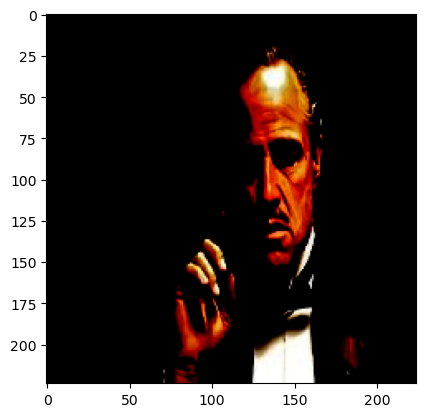

In [45]:
n = 10
sample_image = X_train[n]
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

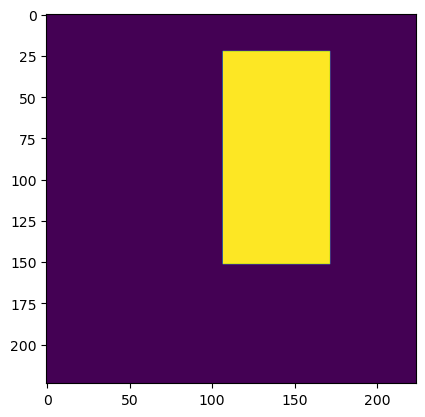

In [46]:
n = 10
sample_mask = masks[n]
final_mask = sample_mask
plt.imshow(sample_mask)

1/1 [==============================] - 0s 167ms/step


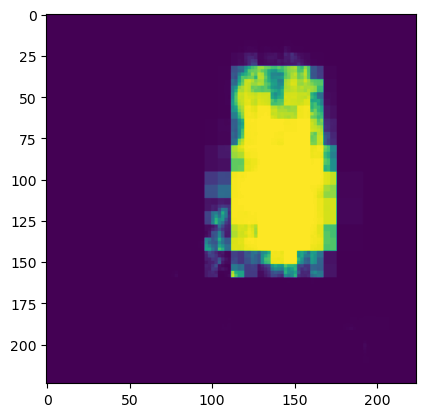

In [47]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
plt.imshow(pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


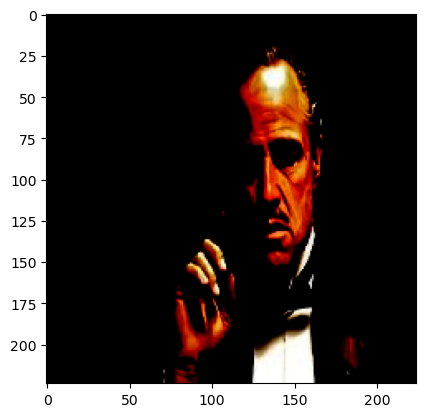

In [48]:
final_pred_mask = np.resize(pred_mask, (224, 224))
final_image = np.resize(sample_image, (224, 224, 3))
plt.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


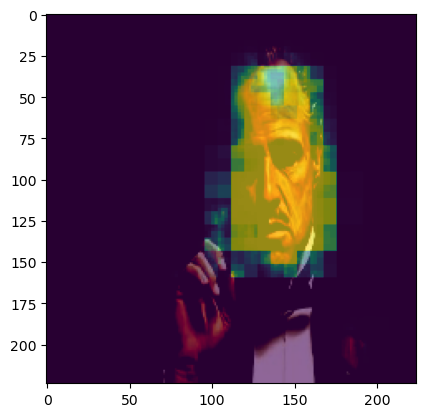

In [49]:
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


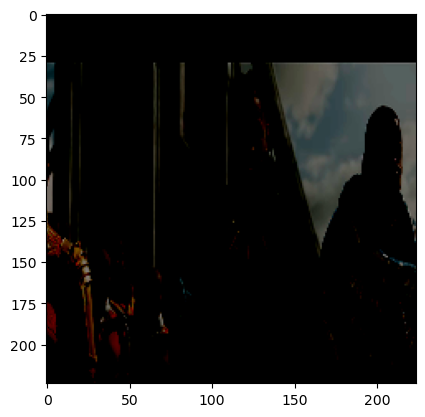

In [50]:
n = 3
sample_image = X_train[n]
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

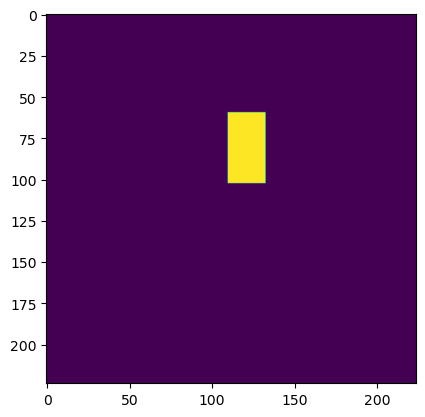

In [51]:
n = 3
sample_mask = masks[n]
final_mask = sample_mask
plt.imshow(sample_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


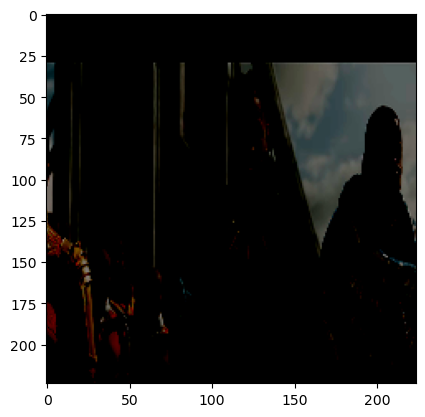

In [52]:
final_pred_mask = np.resize(pred_mask, (224, 224))
final_image = np.resize(sample_image, (224, 224, 3))
plt.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


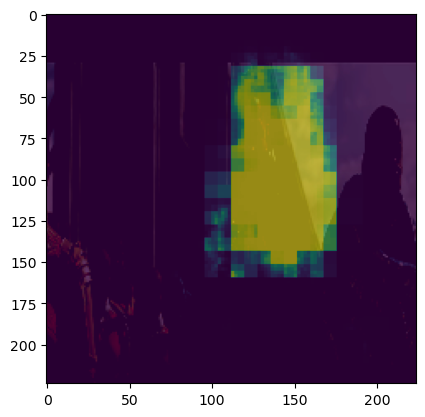

In [53]:
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


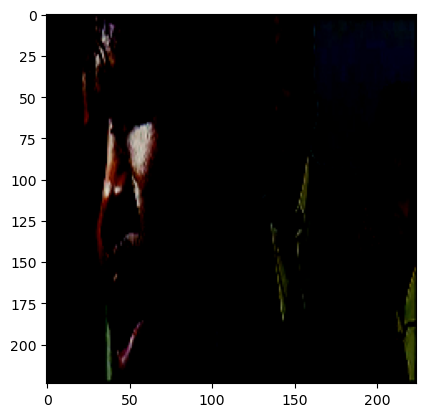

In [54]:
n = 70
sample_image = X_train[n]
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

In [55]:
os.chdir('C:\\Personal\\AI\\Computer_Vision\\')
print('Working directory changed!')
cwd = os.getcwd()
print('\nCurrent working directory: ', cwd)

Working directory changed!

Current working directory:  C:\Personal\AI\Computer_Vision


In [56]:
train_images = 'training_images-20211126T092819Z-001.zip'

In [57]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)



In [58]:
archive = zipfile.ZipFile(train_images, 'r')
archive.extractall()

In [59]:
path="C:\\Personal\\AI\\Computer_Vision\\training_images-20211126T092819Z-001"
metadata = load_metadata(path)

In [60]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels, CV2 used to open file cv2.imread()
    # method loads an image from the specified file. If the image cannot be read 
    #(because of the missing file, improper permissions, or unsupported or invalid format) 
    #then this method returns an empty matrix.
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [61]:
for i, m in enumerate(metadata):
    img_1= load_image(metadata[i].image_path())


In [62]:
df = pd.DataFrame(metadata)

In [63]:
df.to_csv('C:\Personal\AI\Computer_Vision\Check\metadatacsv.csv')

Conclusion
Project was all about how we can make use of a pretrained MobileNet (Transfer Learning) and on top of it add all the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.
Model checkpoint, early stopping and learning rate reducers were used as callbacks.
Data was split into train and validation using 90/10 ratio. Best loss I got is 0.4203 and dice_coefficient of 0.7652 on the training data with just 10 epochs.
Model weights for this were used and then used to predict on validation data to get mask.
Further checked on sample image and imposed mask on the image.
As seen in the above images, it can be seen that model does a very good job in predicting the masks.